In [145]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import sparse as sp
import matplotlib.pyplot as plt
from yellowbrick.target import ClassBalance
import seaborn as sns
from tqdm.auto import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import LineVizNx
import neural_lib as nl

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV

## Data import and preprocessing

Our data:

-  [Heart Disease Dataset](https://www.kaggle.com/datasets/yasserh/heart-disease-dataset)

- [Airline Passenger Satisfaction](https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction)

- [HR Analytics: Job Change of Data Scientists](https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists?select=aug_train.csv)

Import each dataset and remember its numerical features for future preprocessing.

In [3]:
heart_data = pd.read_csv('heart.csv').dropna()
airlines_data = pd.read_csv('air_train.csv').dropna()
hr_data = pd.read_csv('aug_train.csv').dropna()

In [4]:
heart_num_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
heart_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
air_num_features = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
airlines_data.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [6]:
hr_num_features = ['city_development_index', 'training_hours']
hr_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0
8,27107,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,46,1.0
11,23853,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,5000-9999,Pvt Ltd,1,108,0.0


Dropping id columns, ecoding target.

In [7]:
hr_data.drop(columns=['enrollee_id'], inplace=True)
airlines_data.drop(columns=['Unnamed: 0', 'id'], inplace=True)

airlines_data['target'] = airlines_data['satisfaction'].map({'neutral or dissatisfied': 0, 
                                                                     'satisfied': 1})
airlines_data.drop(columns=['satisfaction'], inplace=True)

#### Function for binarizing data

Here we create bins for numeric features, and then use OHE for all attributes.

In [119]:
def bin_data(num_features, X):
    Xc = X.drop(columns=['target']).copy()
    
    for feature in num_features:
        data = Xc[feature]
        Xc[f'{feature}_bin']= pd.cut(data, np.arange(data.min(), data.max(), (data.min() + data.max()) / 10), 
                                    include_lowest=True)
    Xc.drop(columns=num_features, inplace=True)
    
    Xc = pd.get_dummies(Xc.astype(object), drop_first=True).astype(bool)
    
    X_train, X_test, y_train, y_test = train_test_split(
                                                    Xc, 
                                                    X["target"], 
                                                    test_size=0.2, 
                                                    random_state=10, 
                                                    stratify=X["target"])
    return X_train, X_test, y_train, y_test

In [120]:
heart_X_train, heart_X_test, heart_y_train, heart_y_test = bin_data(heart_num_features, heart_data)

air_X_train, air_X_test, air_y_train, air_y_test = bin_data(air_num_features, airlines_data)

hr_X_train, hr_X_test, hr_y_train, hr_y_test = bin_data(hr_num_features, hr_data)

Plots for class distributions

In [103]:
lbls = [['Healthy', 'Heart Disease'], ['Dissatisfied', 'Satisfied'], ['Not looking for a job change', 'Looking for a job change']]
targets = [(heart_y_train, heart_y_test), (air_y_train, air_y_test), (hr_y_train, hr_y_test)]

for i, j in enumerate(zip(lbls, targets)):
    visualizer = ClassBalance(labels=j[0])
    visualizer.fit(j[1][0], j[1][1])   
    visualizer.show(outpath=f'/Users/sasaatlasov/Desktop/plots/class_balance_{i}.pdf', dpi=200, clear_figure=True); 

<Figure size 800x550 with 0 Axes>

## Feature Selection

To select the most important features, I will use filter method (used it in one ML course). For each feature $j$ the following t-stat is counted:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

where $\mu$, $\sigma$, $n$ mean, standard deviation and number of objects in classes correspondingly. The higher the statistic's value, the more important the feature is.

In [53]:
def count_stat(feature, X, y):
    a = abs(X[feature][y == 1].mean() - X[feature][y==0].mean())
    b = np.sqrt((len(X[feature][y == 1]) * np.std(X[feature][y == 1]) ** 2 + 
                 len(X[feature][y == 0]) * np.std(X[feature][y == 0]) ** 2) / 
                len(X[feature]))
    return a / b

def get_best_features(X_train, X_test, y_train, n=10):
    statistics = []
    for i in X_train.columns:
        statistics.append(count_stat(i, X_train, y_train))
    features_idx = np.array(statistics).argsort()[-n:]
    best_features = X_train.columns[features_idx]
    
    return X_train[best_features], X_test[best_features]

## Training

Each baseline model is train using 5-fold cross-validation, with grid-search hyperparameters tuning. 

Tuning for numer of concepts is not realized yet.

### Finding best number of features and concepts

In [64]:
def fit_ConceptNetwork(X_train, y_train, n_concepts=5):
    K = FormalContext(data=X_train.values, target=y_train.values, attribute_names=X_train.columns, 
                           object_names=list(map(str, range(len(X_train)))))
    L = ConceptLattice.from_context(K, algo='Sofia', is_monotone=True)
    
    for c in L:
        y_preds = np.zeros(K.n_objects)
        y_preds[list(c.extent_i)] = 1
        c.measures['f1_score'] = f1_score(y_train, y_preds)
    best_concepts = list(L.measures['f1_score'].argsort()[::-1][:n_concepts])
    cn = nl.ConceptNetwork.from_lattice(L, best_concepts, targets=sorted(set(y_train)))
    cn.fit(X_train, y_train)
    
    return cn


def finetune_CN(X_train, X_test, y_train, y_test, n_features, n_concepts):
    results = []
    for i in tqdm(n_features):
        for j in n_concepts:
            X_train_l, X_test_l = get_best_features(X_train, X_test, y_train, i)
            cn = fit_ConceptNetwork(X_train_l, y_train, j)
            preds = cn.predict(X_test_l)
            results.append(((i, j), f1_score(y_test, preds)))
            
    dd = pd.DataFrame(columns=['Features', 'Concepts', 'F1'])

    for i, j in enumerate(results):
        dd.loc[i, 'Features'] = j[0][0]
        dd.loc[i, 'Concepts'] = j[0][1]
        dd.loc[i, 'F1'] = j[1]
        
    return dd.pivot(index="Features", columns="Concepts", values="F1").astype(float)

In [65]:
n_feat = [10, 30, 50, 100]
n_conc = [1, 3, 5, 7, 9]

  0%|          | 0/4 [00:00<?, ?it/s]

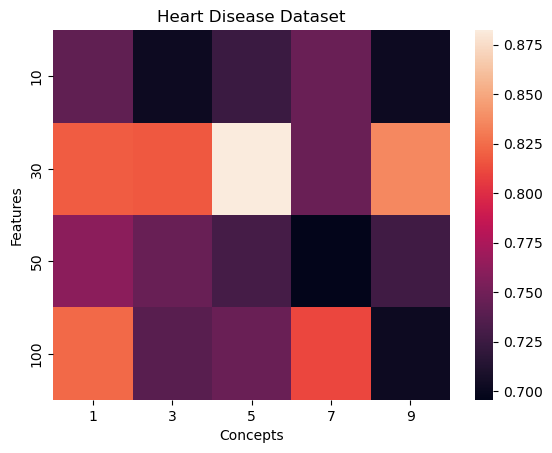

In [67]:
res_heart = finetune_CN(heart_X_train, heart_X_test, heart_y_train, heart_y_test,
                 n_feat, n_conc)

plt.figure(dpi=100)
sns.heatmap(res_heart)
plt.title('Heart Disease Dataset');

  0%|          | 0/4 [00:00<?, ?it/s]

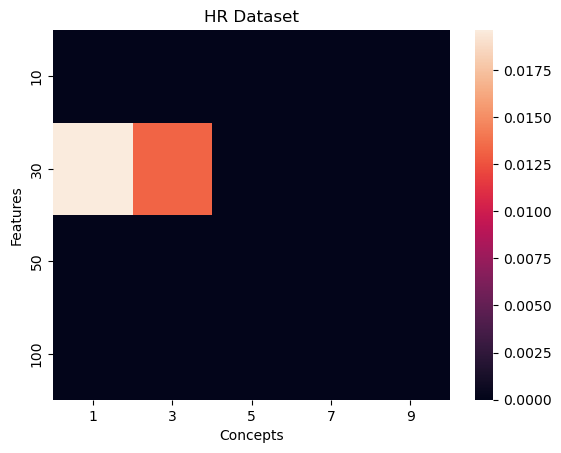

In [68]:
res_hr = finetune_CN(hr_X_train, hr_X_test, hr_y_train, hr_y_test,
                 n_features, n_concepts)

plt.figure(dpi=100)
sns.heatmap(res_hr)
plt.title('HR Dataset');

  0%|          | 0/4 [00:00<?, ?it/s]

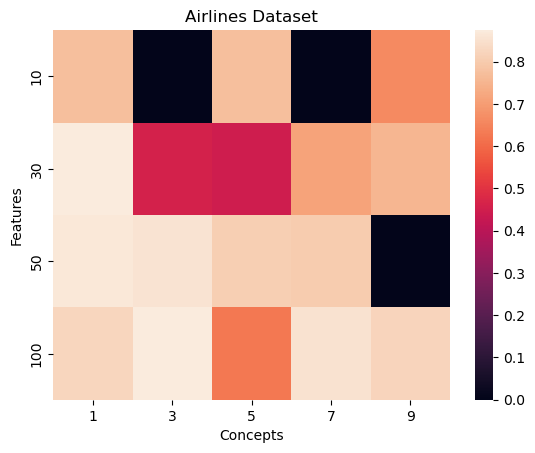

In [69]:
res_air = finetune_CN(air_X_train, air_X_test, air_y_train, air_y_test,
                 n_features, n_concepts)

plt.figure(dpi=100)
sns.heatmap(res_air)
plt.title('Airlines Dataset');

### Сomparison with classical machine learning models

In [107]:
gb = CatBoostClassifier(verbose=False)
nb = GaussianNB()
lr = LogisticRegression(verbose=False)
rf = RandomForestClassifier()
knn = KNeighborsClassifier()


models = [gb, nb, lr, rf, knn]

model_name = ['CatBoost', 'NaiveBayes', 
             'LogisticRegression', 'RandomForest', 'kNN']

param_grids = [{'iterations': [200, 500, 1000], 'depth': [3, 6]},
              {'priors': [(0.5, 0.5), None]},
              {'C': np.linspace(0, 2, 5)},
              {'n_estimators': [200, 500, 1000], 'criterion': ['gini', 'log_loss'], 
               'max_depth': [3, 5, 7]},
              {'n_neighbors': [2, 5, 6], 'p': [2, 3]}]

In [108]:
def add_scores(results, name, k, model, X_test, y_test):
    preds = model.predict(X_test)
    results.loc[k,"Model"] = name
    results.loc[k,"Accuracy"] = np.round(accuracy_score(y_test, preds), 3)
    results.loc[k,"F1-score"] = np.round(f1_score(y_test, preds), 3)
    results.loc[k,"AUC-ROC"] = np.round(roc_auc_score(y_test, preds), 3)
    

def get_results(X_train, X_test, y_train, y_test, n_features=10, n_concepts=3):
    results = pd.DataFrame(columns = ["Model", 'Accuracy', 'F1-score', 'AUC-ROC'])
    X_train, X_test = get_best_features(X_train, X_test, y_train, n_features)
    cn = fit_ConceptNetwork(X_train, y_train, n_concepts)
    add_scores(results, 'ConceptNetwork', 0, cn, X_test, y_test)
    
    for i, j in tqdm(enumerate(models)):
        best = GridSearchCV(j, param_grids[i], scoring='f1', verbose=0,
                            cv=5).fit(X_train, y_train).best_estimator_ 
        add_scores(results, model_name[i], i+1, best, X_test, y_test)
    
    return results

In [109]:
heart = get_results(heart_X_train, heart_X_test, heart_y_train, heart_y_test, 30, 5)
heart

0it [00:00, ?it/s]

,Model,Accuracy,F1-score,AUC-ROC
0,ConceptNetwork,0.836,0.844,0.838
1,CatBoost,0.803,0.812,0.805
2,NaiveBayes,0.639,0.738,0.613
3,LogisticRegression,0.82,0.831,0.82
4,RandomForest,0.77,0.788,0.769
5,kNN,0.77,0.794,0.766


In [110]:
hr = get_results(hr_X_train, hr_X_test, hr_y_train, hr_y_test, 30, 1)
hr

0it [00:00, ?it/s]

,Model,Accuracy,F1-score,AUC-ROC
0,ConceptNetwork,0.834,0.0,0.5
1,CatBoost,0.859,0.529,0.706
2,NaiveBayes,0.839,0.368,0.616
3,LogisticRegression,0.864,0.567,0.734
4,RandomForest,0.855,0.487,0.679
5,kNN,0.846,0.433,0.649


In [112]:
air = get_results(air_X_train, air_X_test, air_y_train, air_y_test, 30, 1)
air

0it [00:00, ?it/s]

,Model,Accuracy,F1-score,AUC-ROC
0,ConceptNetwork,0.861,0.83,0.852
1,CatBoost,0.939,0.928,0.936
2,NaiveBayes,0.875,0.846,0.865
3,LogisticRegression,0.913,0.898,0.91
4,RandomForest,0.912,0.893,0.904
5,kNN,0.925,0.912,0.922


#### Some results

Our main metric is F1-score, but we will also look at accuracy and AUC-ROC. 

As we can see, the results depend on dataset. For example, for HR dataset f1-score is 0 (I experimented with number of features and concepts, but it was still 0). Same for airlines data, I hope it is not penalized now, and I will be able to tune for this problems. In case with predictions of heart disease, f1-score is quite nice and higher comparing to baseline models.  

## Trying different nonlinearities

In [121]:
import torch
import torch.nn as nn

In [210]:
heart_X_train, heart_X_test = get_best_features(heart_X_train, heart_X_test, heart_y_train, 30)

air_X_train, air_X_test = get_best_features(air_X_train, air_X_test, air_y_train, 30)

hr_X_train, hr_X_test = get_best_features(hr_X_train, hr_X_test, hr_y_train, 30)

In [135]:
def add_scores(results, name, k, model, X_test, y_test):
    preds = model.predict(X_test)
    results.loc[k,"Model"] = name
    results.loc[k,"Accuracy"] = np.round(accuracy_score(y_test, preds), 3)
    results.loc[k,"F1-score"] = np.round(f1_score(y_test, preds), 3)
    results.loc[k,"AUC-ROC"] = np.round(roc_auc_score(y_test, preds), 3)
    
def fit_ConceptNetwork(X_train, y_train, nonlin, n_concepts=5):
    K = FormalContext(data=X_train.values, target=y_train.values, attribute_names=X_train.columns, 
                           object_names=list(map(str, range(len(X_train)))))
    L = ConceptLattice.from_context(K, algo='Sofia', is_monotone=True)
    
    for c in L:
        y_preds = np.zeros(K.n_objects)
        y_preds[list(c.extent_i)] = 1
        c.measures['f1_score'] = f1_score(y_train, y_preds)
    best_concepts = list(L.measures['f1_score'].argsort()[::-1][:n_concepts])
    cn = nl.ConceptNetwork.from_lattice(L, best_concepts, targets=sorted(set(y_train)))
    cn.fit(X_train, y_train)
    
    return cn

def conduct_experiment(X_train, X_test, y_train, y_test, n_conc):
    results = pd.DataFrame(columns = ["Model", 'Accuracy', 'F1-score', 'AUC-ROC'])
    nls = [nn.ReLU, nn.LeakyReLU, nn.GELU, nn.ELU, nn.Tanh]
    names = ['ReLU','LeakyReLU', 'GELU', 'ELU', 'Tanh']
    for i, j in tqdm(enumerate(nls)):
        cn = fit_ConceptNetwork(X_train, y_train, j, n_conc)
        add_scores(results, names[i], i+1, cn, X_test, y_test)
    return results

In [136]:
heart_nl = conduct_experiment(heart_X_train, heart_X_test, heart_y_train, heart_y_test, 5)
heart_nl

0it [00:00, ?it/s]

,Model,Accuracy,F1-score,AUC-ROC
1,ReLU,0.869,0.879,0.868
2,LeakyReLU,0.836,0.853,0.832
3,GELU,0.754,0.789,0.746
4,ELU,0.82,0.836,0.817
5,Tanh,0.803,0.829,0.797


In [137]:
hr_nl = conduct_experiment(hr_X_train, hr_X_test, hr_y_train, hr_y_test, 1)
hr_nl

0it [00:00, ?it/s]

,Model,Accuracy,F1-score,AUC-ROC
1,ReLU,0.834,0.0,0.5
2,LeakyReLU,0.834,0.0,0.5
3,GELU,0.832,0.02,0.503
4,ELU,0.834,0.0,0.5
5,Tanh,0.834,0.0,0.5


In [138]:
air_nl = conduct_experiment(air_X_train, air_X_test, air_y_train, air_y_test, 1)
air_nl

0it [00:00, ?it/s]

,Model,Accuracy,F1-score,AUC-ROC
1,ReLU,0.906,0.886,0.899
2,LeakyReLU,0.837,0.807,0.831
3,GELU,0.882,0.859,0.876
4,ELU,0.881,0.859,0.876
5,Tanh,0.838,0.803,0.829


## Plot best networks

In [245]:
cn = fit_ConceptNetwork(air_X_train, air_y_train, nn.ReLU, 1)

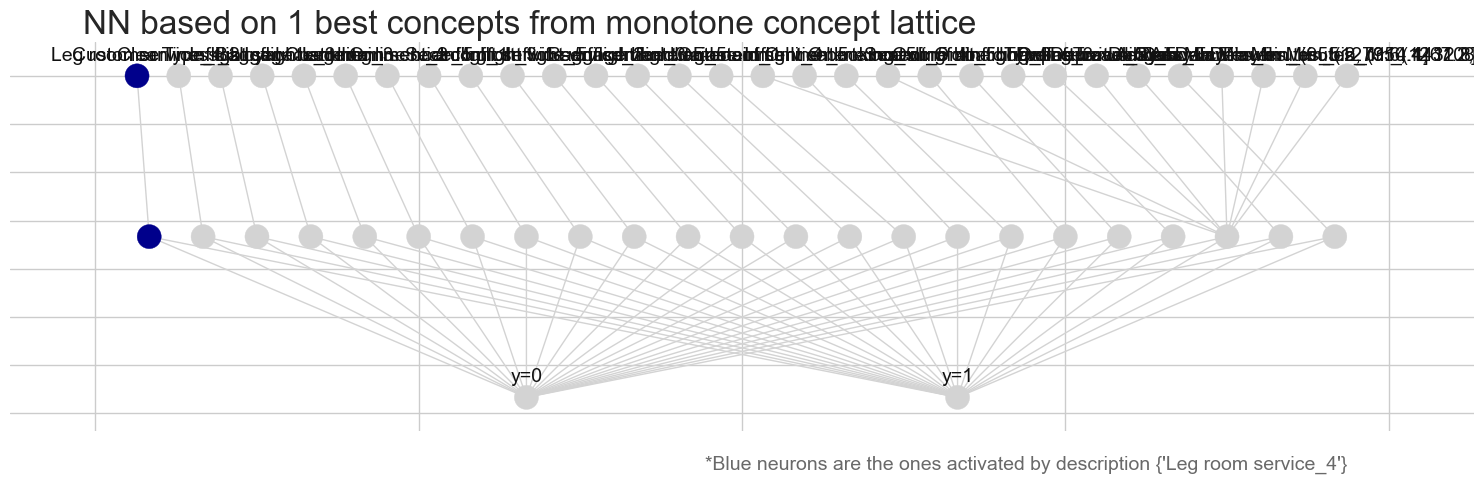

In [246]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes)))

descr = {cn.attributes[0]}

traced = cn.trace_description(descr, include_targets=False)

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 1 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.savefig('/Users/sasaatlasov/Desktop/plots/air_viz.pdf', dpi=200)
plt.show()

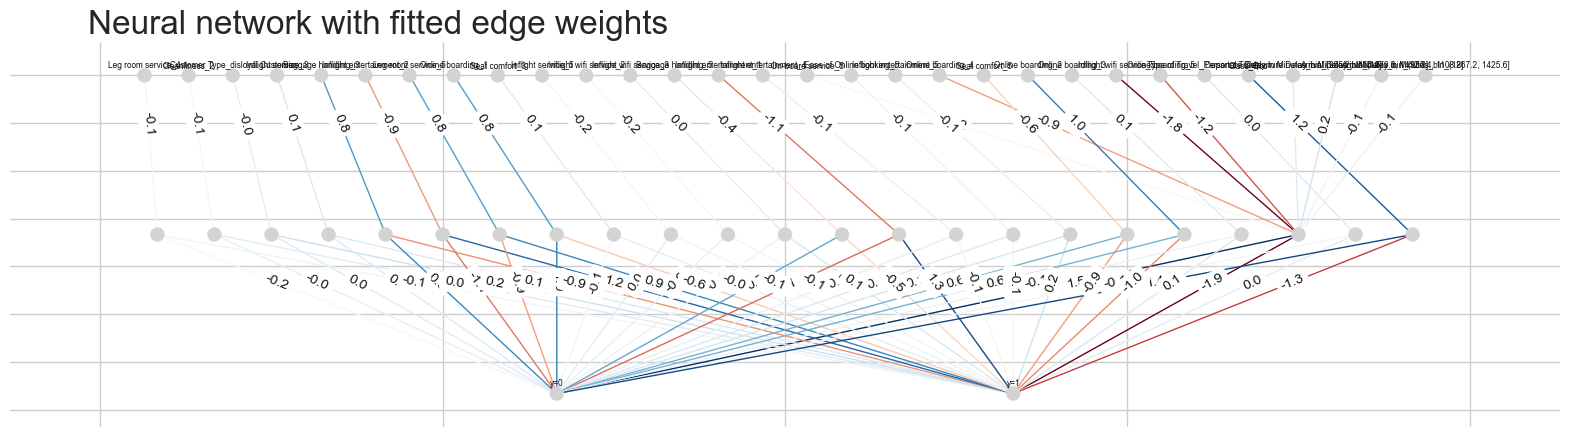

In [247]:
edge_weights = cn.edge_weights_from_network()

fig, ax = plt.subplots(figsize=(20,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
    
               node_size=100,
               node_label_font_size=6
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.subplots_adjust()
plt.savefig('/Users/sasaatlasov/Desktop/plots/air_viz_1.pdf', dpi=200)
plt.show()

In [248]:
cn = fit_ConceptNetwork(hr_X_train, hr_y_train, nn.GELU, 1)

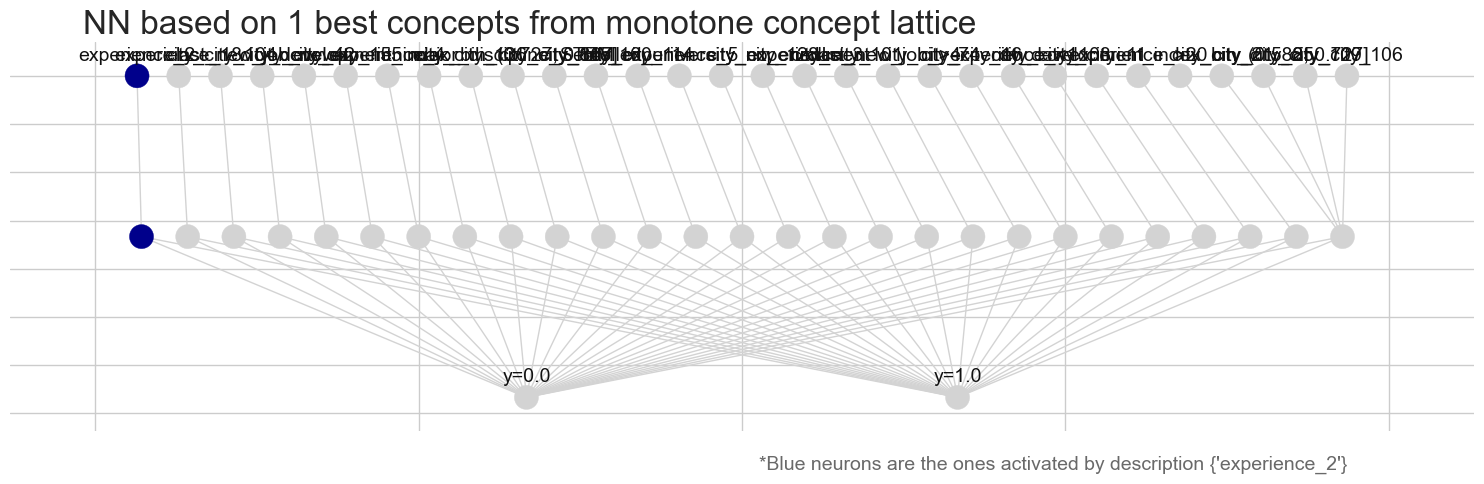

In [249]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes)))

descr = {cn.attributes[0]}

traced = cn.trace_description(descr, include_targets=False)

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 1 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.savefig('/Users/sasaatlasov/Desktop/plots/hr_viz.pdf', dpi=200)
plt.show()

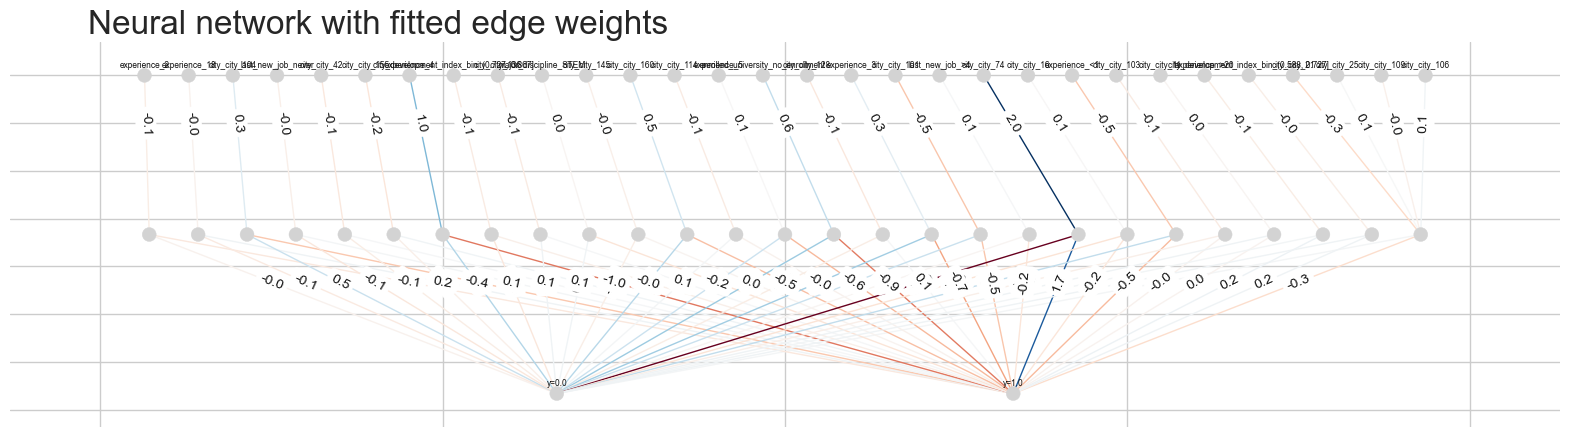

In [250]:
edge_weights = cn.edge_weights_from_network()

fig, ax = plt.subplots(figsize=(20,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
               node_size=100,
               node_label_font_size=6
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.subplots_adjust()
plt.savefig('/Users/sasaatlasov/Desktop/plots/hr_viz_1.pdf', dpi=200)
plt.show()

In [251]:
cn = fit_ConceptNetwork(heart_X_train, heart_y_train, nn.ReLU, 5)

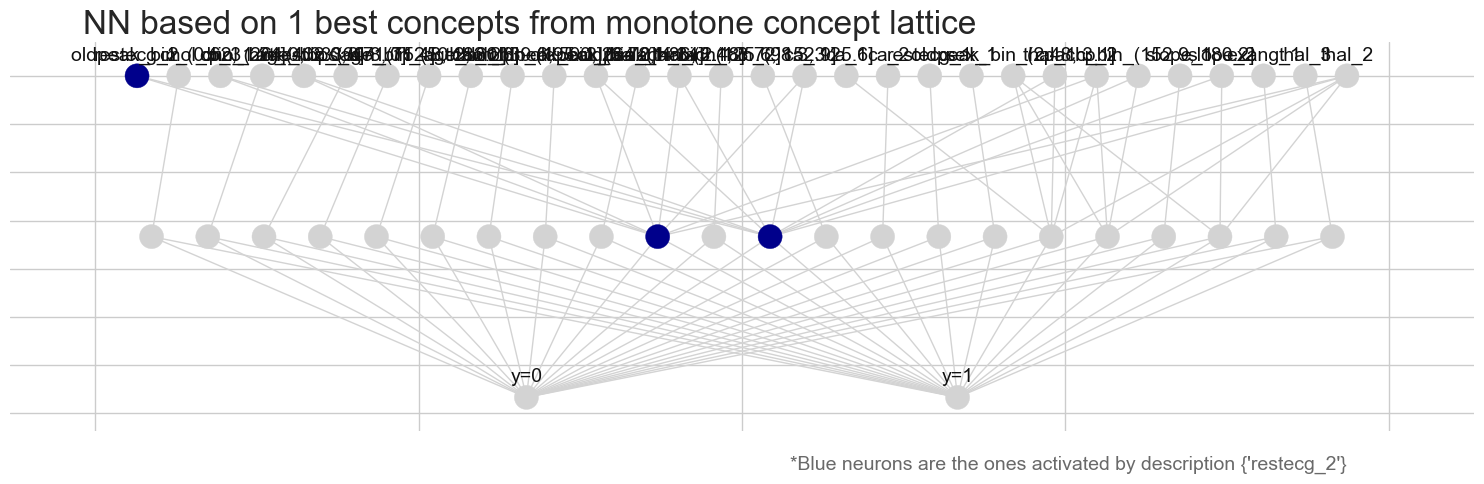

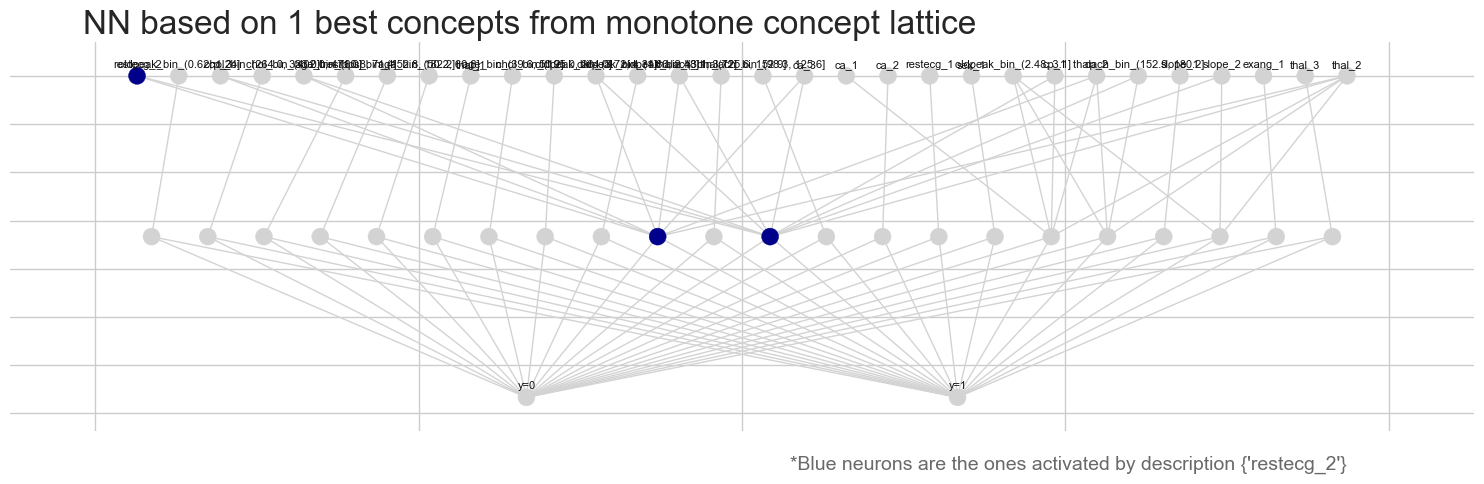

In [252]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes)))

descr = {cn.attributes[0]}

traced = cn.trace_description(descr, include_targets=False)

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 1 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.savefig('/Users/sasaatlasov/Desktop/plots/hr_viz.pdf', dpi=200)
plt.show()
descr = {cn.attributes[0]}

traced = cn.trace_description(descr, include_targets=False)

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))],
    node_size=150,
    node_label_font_size=8
)
plt.title(f'NN based on 1 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.savefig('/Users/sasaatlasov/Desktop/plots/heart_viz.pdf')
plt.show()

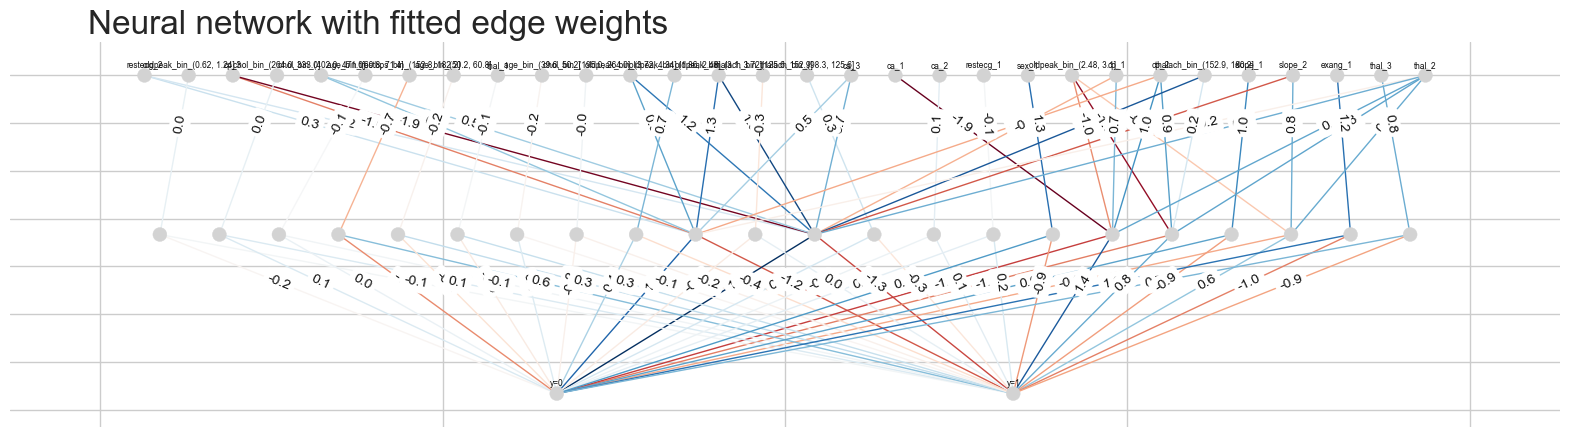

In [253]:
edge_weights = cn.edge_weights_from_network()

fig, ax = plt.subplots(figsize=(20,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
               node_size=100,
               node_label_font_size=6
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.subplots_adjust()
plt.savefig('/Users/sasaatlasov/Desktop/plots/heart_viz_1.pdf', dpi=200)
plt.show()